In [1]:
import os
import h5py
import numpy as np 

In [2]:
from scipy.special import erf 

In [3]:
import corner as DFM
import matplotlib.pyplot as plt

In [4]:
dat_dir = '/scratch/gpfs/chhahn/21cmlfi/'

In [5]:
f = h5py.File(os.path.join(dat_dir, '21cmlfi.hdf5'), 'r')

thetas = f['theta'][...]
Del2 = f['Del2_21_nonoise'][...]
f.close()

In [6]:
lbl_params = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])

prior_params = [[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]]

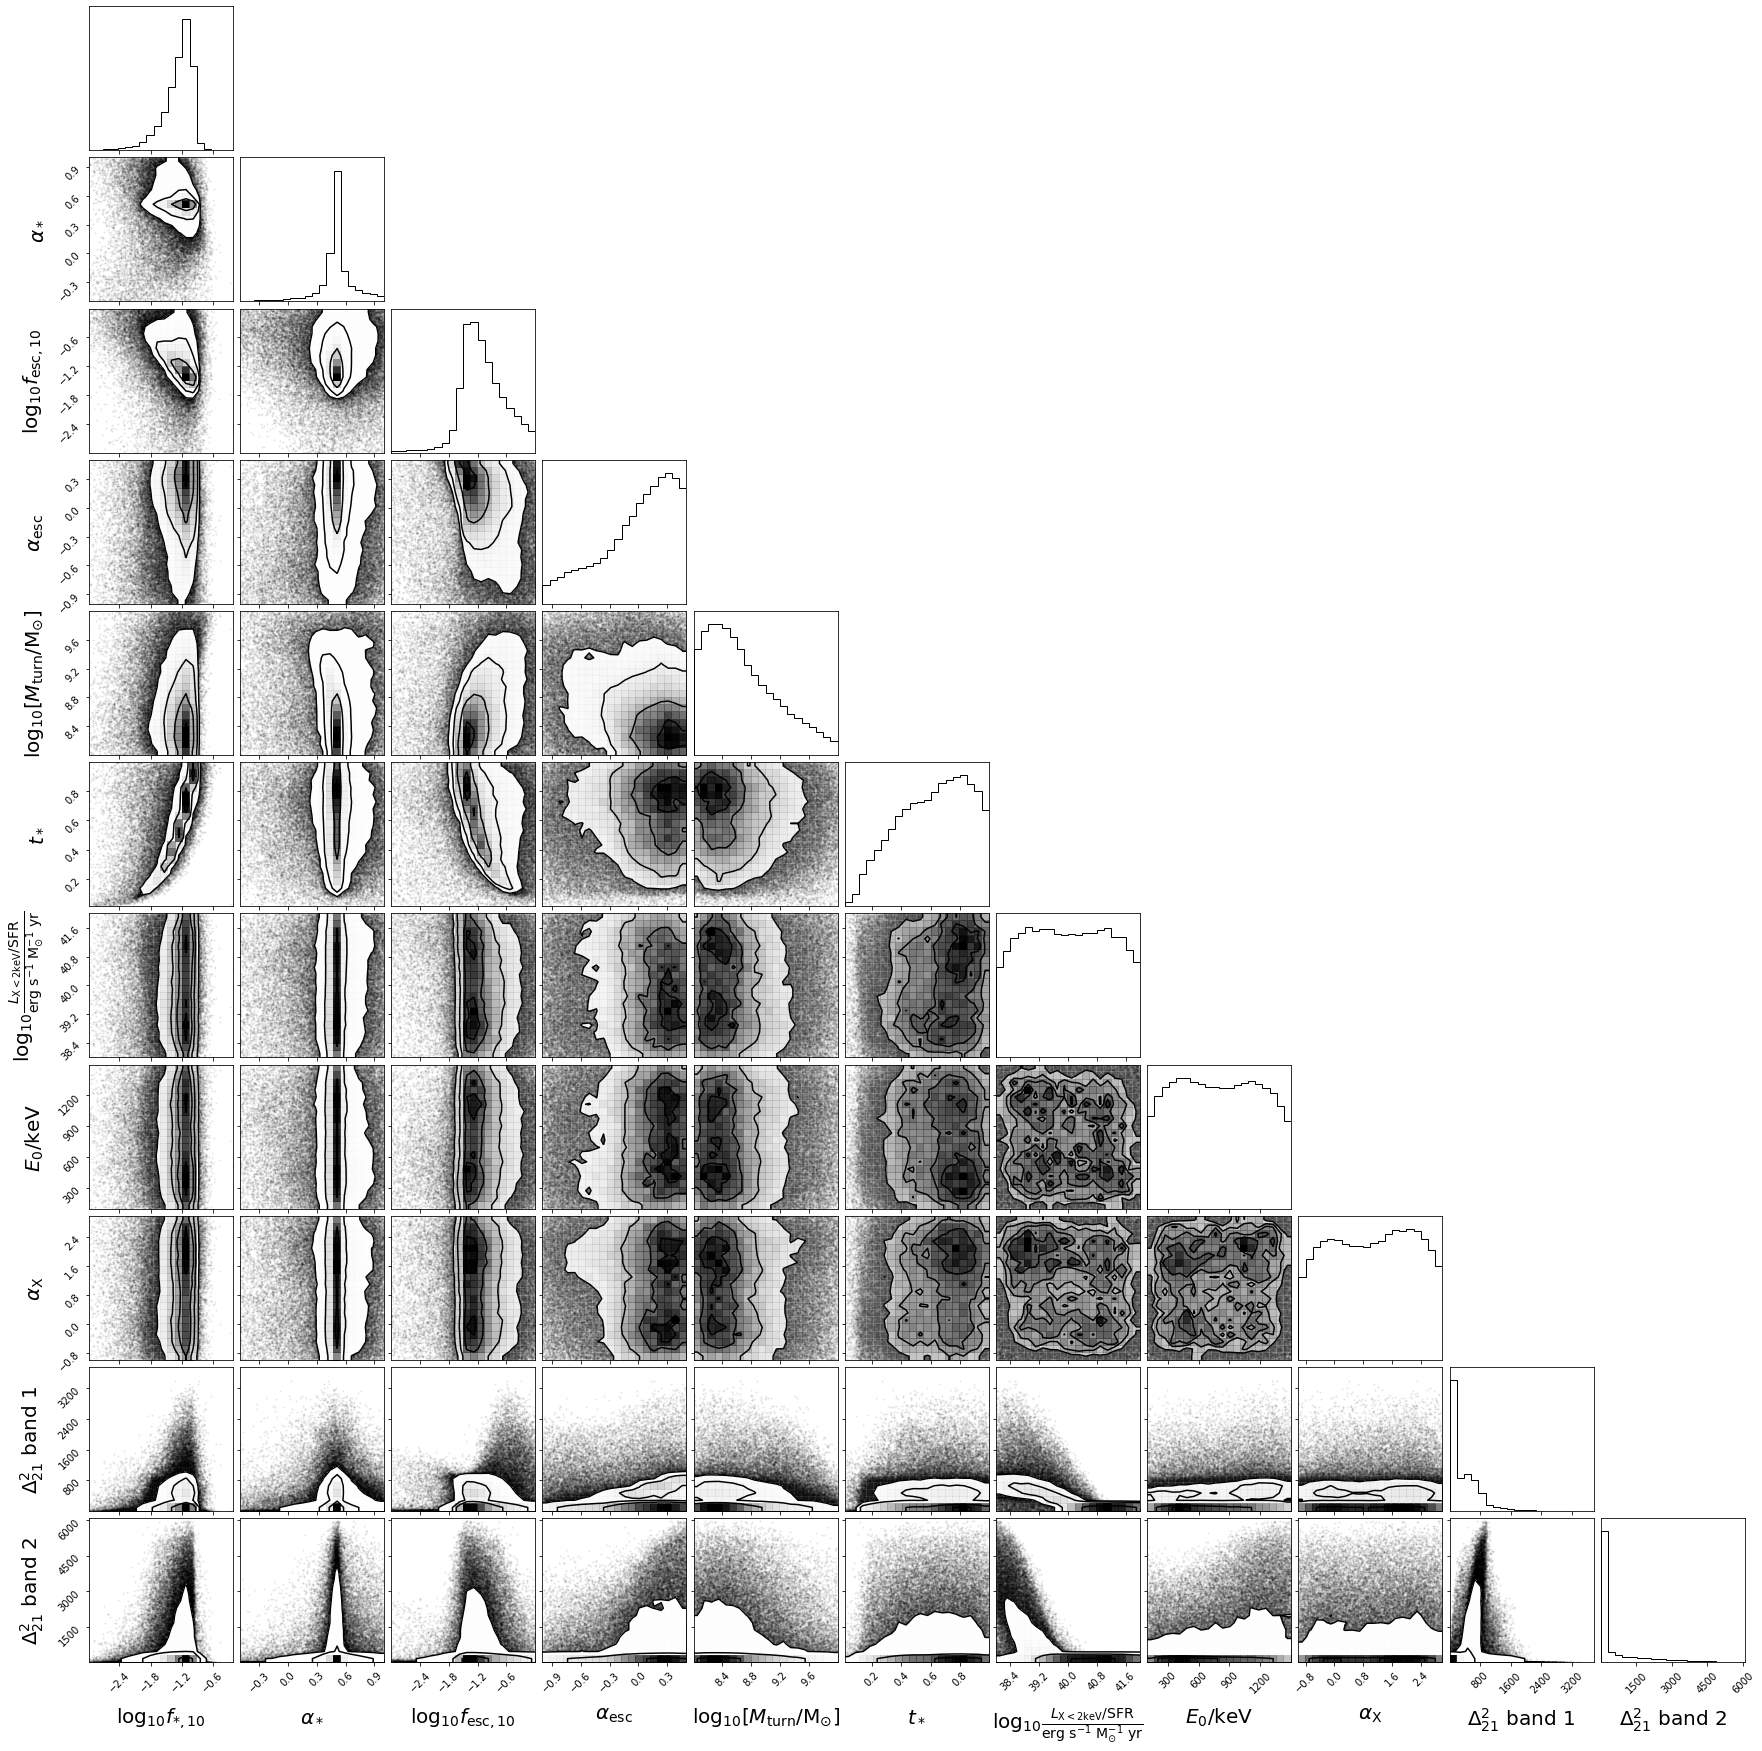

In [7]:
fig = DFM.corner(np.concatenate([thetas, Del2], axis=1), 
                 labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', 
                                      r'$\Delta_{21}^2$ band 2'], 
                 label_kwargs={'fontsize': 20})

# apply noise model

$$\delta x \sim \frac{1}{2} (1 + {\rm erf} \frac{\delta x}{\sqrt{2} \sigma})$$

In [8]:
def noise_model(sigma, size=1): 
    dxs = []
    for i in range(size): 
        u = 1. 
        pdx = 0.
        while pdx < u:
            dx = np.random.uniform(-1e4, 1e4)#5*sigma, 5*sigma)
            u = np.random.uniform()
            pdx = 0.5 * (1 + erf(dx/np.sqrt(2)/sigma)) 
        dxs.append(dx)
    return np.array(dxs)

In [9]:
Del2_noisys = [] 
for i, sigma_scale in enumerate([1., 3., 9., 27., 81.]): 
    sigma_band1 = 3600 / sigma_scale
    sigma_band2 = 300 / sigma_scale

    dxs_band1 = noise_model(sigma_band1, size=Del2.shape[0])
    dxs_band2 = noise_model(sigma_band2, size=Del2.shape[0])
    
    _Del2_noisy = Del2 + np.concatenate([dxs_band1[:,None], dxs_band2[:,None]], axis=1)
    Del2_noisys.append(_Del2_noisy)

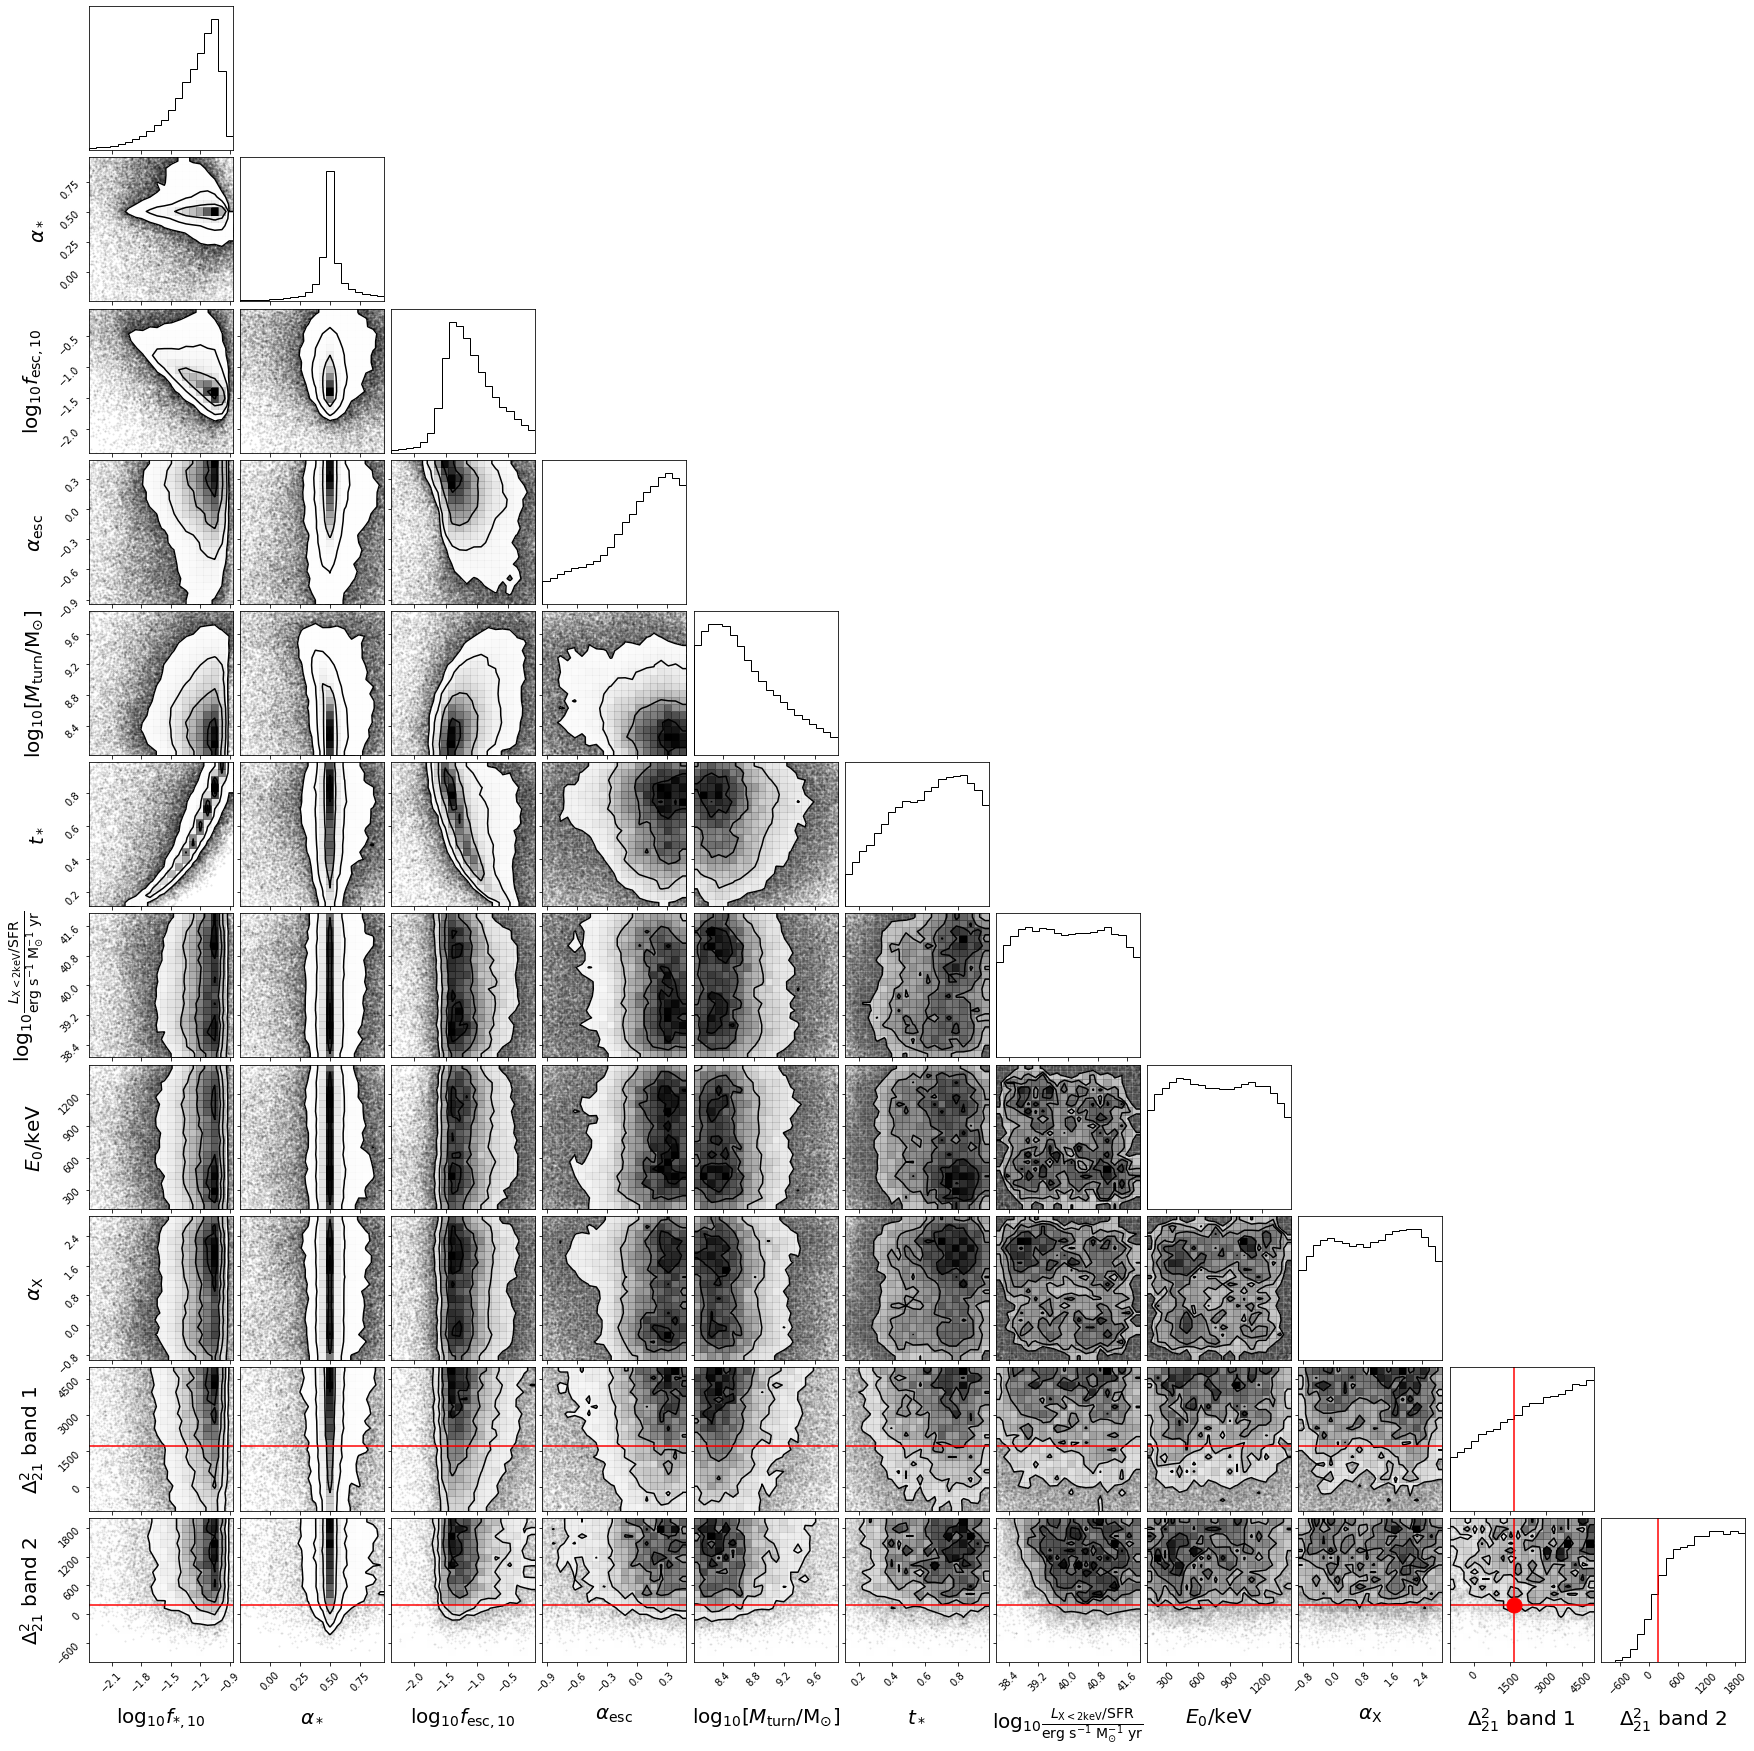

In [10]:
fig = DFM.corner(np.concatenate([thetas, Del2_noisys[0]], axis=1),
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T] + [(-1000., 5000), (-1000., 2000)], 
                 labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                 label_kwargs={'fontsize': 20})
DFM.overplot_points(fig, [[None for _ in lbl_params] + [1700, 200]], color='r', markersize=30)
DFM.overplot_lines(fig, [None for _ in lbl_params] + [1700, 200], color='r')

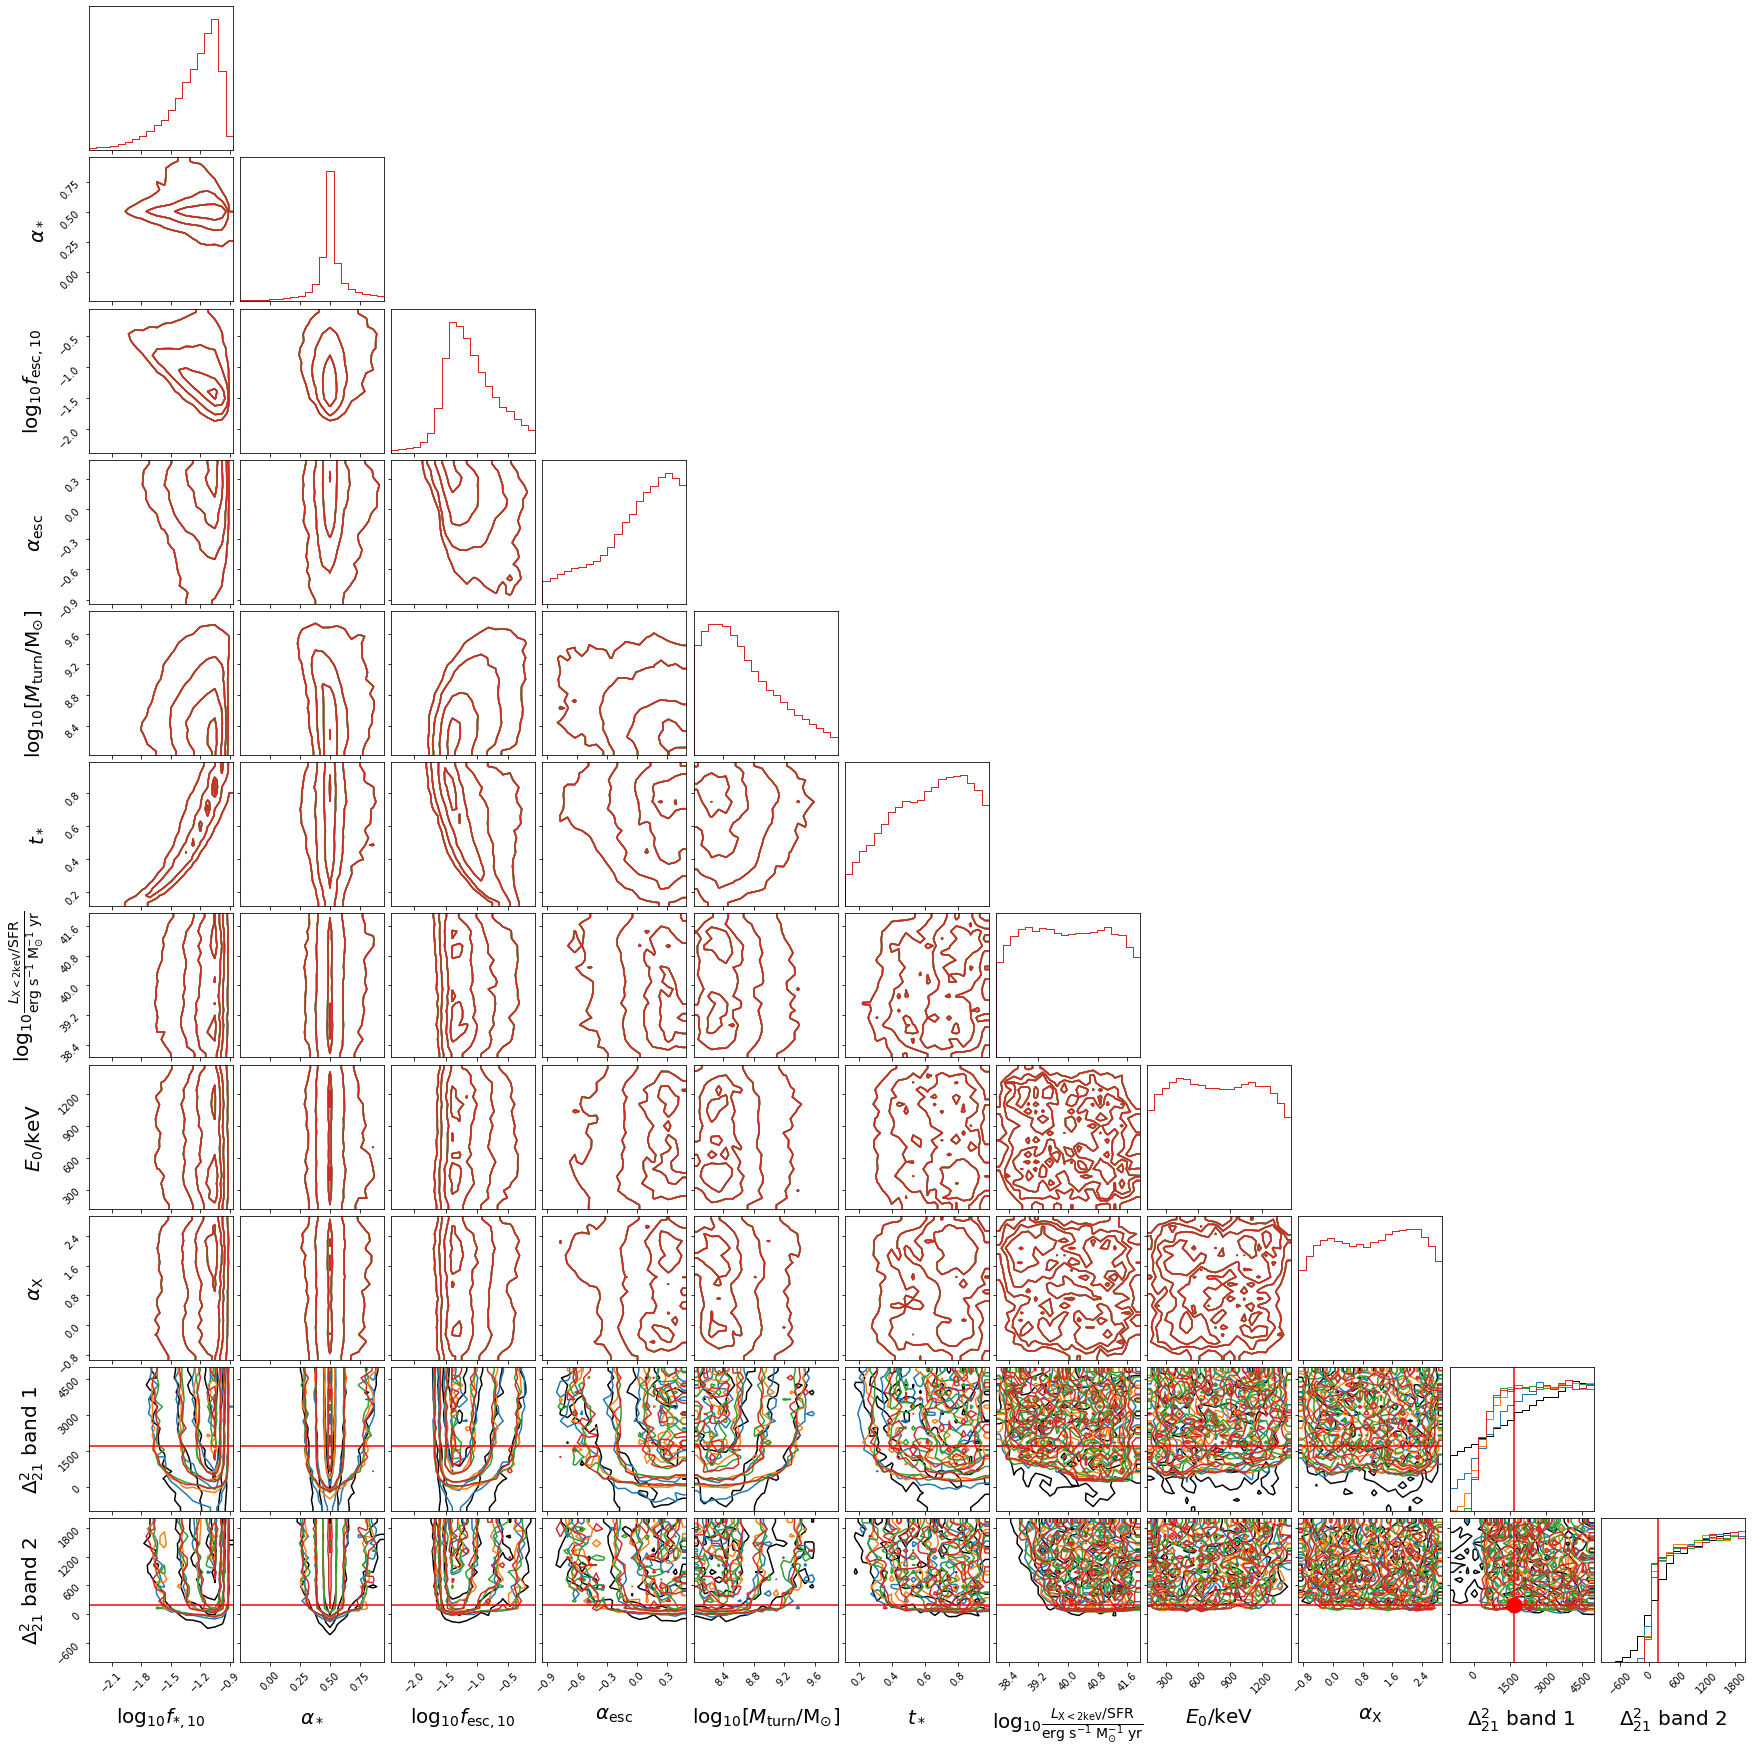

In [12]:
fig = DFM.corner(np.concatenate([thetas, Del2_noisys[0]], axis=1), color='k',
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T] + [(-1000., 5000), (-1000., 2000)], 
                 labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                 label_kwargs={'fontsize': 20}, hist_kwargs={'density': True}, 
                 plot_density=False, plot_datapoints=False)

for i, _Del2_noisy in enumerate(Del2_noisys[1:]): 
    _ = DFM.corner(np.concatenate([thetas, _Del2_noisy], axis=1), color='C%i' % i, 
                     range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T] + [(-1000., 5000), (-1000., 2000)],  
                     labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                     label_kwargs={'fontsize': 20}, hist_kwargs={'density': True}, 
                     plot_density=False, plot_datapoints=False, fig=fig)
DFM.overplot_points(fig, [[None for _ in lbl_params] + [1700, 200]], color='r', markersize=30)
DFM.overplot_lines(fig, [None for _ in lbl_params] + [1700, 200], color='r')

34
55
84
94
67


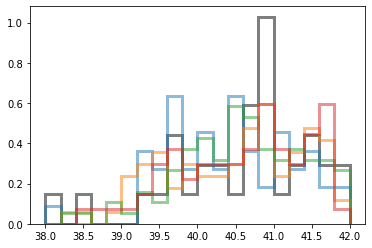

In [15]:
for D2, col in zip(Del2_noisys, ['k', 'C0', 'C1', 'C2', 'C3']): 
    is_close = ((D2[:,0] > 1550) & (D2[:,0] < 1850) & 
                (D2[:,1] > 50) & (D2[:,1] < 350))
    print(np.sum(is_close))
    plt.hist(thetas[:,6][is_close], range=(38, 42), bins=20, alpha=0.5, density=True, 
             histtype='step', linewidth=3, color=col)

In [19]:
f = h5py.File(os.path.join(dat_dir, '21cmlfi.hdf5'), 'a')
f.create_dataset('Del2_21_noise', data=Del2_noisy)
f.close()

In [20]:
f = h5py.File(os.path.join(dat_dir, '21cmlfi.hdf5'), 'a')

for sigma_scale, Del2_noisy in zip([3., 9., 27., 81], Del2_noisys): 
    f.create_dataset('Del2_21_noise_%ix' % int(sigma_scale), data=Del2_noisy)
f.close()